In [20]:
!pip install svgwrite cairosvg rdp
!pip install opencv-python-headless numpy matplotlib
!pip install bezier
!pip install svg2png
!pip install cairosvg
!pip install svgwrite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 46.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xgboost 2.1.1 requires nvidia-nccl-cu12; platform_system == "Linux" and platform_machine != "aarch64", which is not installed.
accelerate 0.32.1 requires numpy<2.0.0,>=1.17, but you have numpy 2.0.1 which is incompatible.
albucore 0.0.13 requires numpy<2,>=1.24.4, but you have numpy 2.0.1 which is incompatible.
arviz 0.18.0 requires numpy<2.0,>=1.23.0, but you have numpy 2.0.1 which is incompatible.
cudf-cu12 24.4.1 requires numpy<2.0

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy.interpolate import splprep, splev



In [3]:
 # csv_path='/content/occlusion2.csv'
# csv_path='/content/occlusion2_sol.csv'
# csv_path='/content/occlusion2.csv'
csv_path='/content/isolated.csv'
# Process the CSV file
path_XYs = read_csv(csv_path)
# print(path_XYs)
# Plot the shapes
# fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 8))
# plot(path_XYs, 'Original Data', axs[0])

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []

    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs

def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for XYs in paths_XYs:
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()





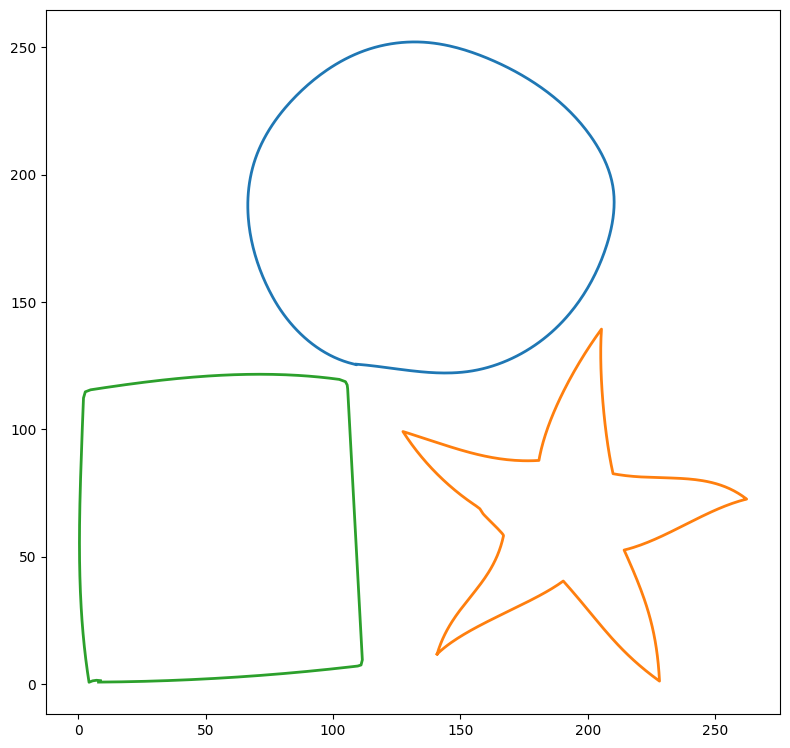

In [5]:

# Read the CSV file
csv_path = '/content/isolated.csv'
paths_XYs = read_csv(csv_path)
plot(paths_XYs)





now we will detect the 2d shapes -- initial intuition





The below algorithm is used for regularization of shapes - works good for individual shapes which are overlapping eachother

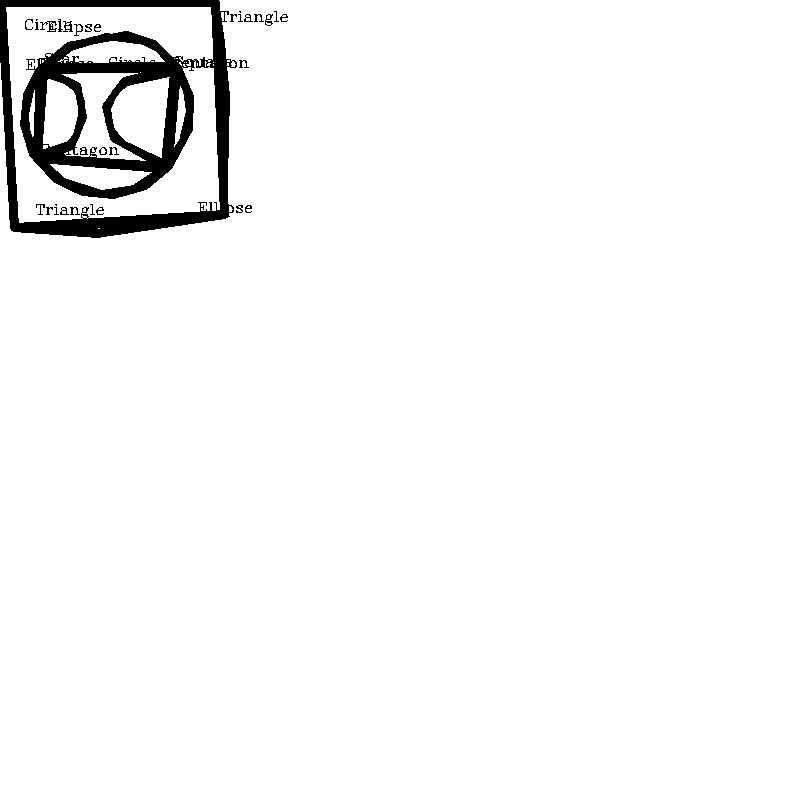

Detected Pentagon at (0, -4)
Detected Triangle at (35, 214)
Detected Ellipse at (197, 212)
Detected Triangle at (219, 21)
Detected Square at (2, -2)
Detected Circle at (23, 29)
Detected Pentagon at (39, 154)
Detected Ellipse at (25, 69)
Detected Ellipse at (38, 68)
Detected Pentagon at (169, 67)
Detected Circle at (107, 67)
Detected Square at (173, 66)
Detected Star at (43, 63)
Detected Ellipse at (46, 31)


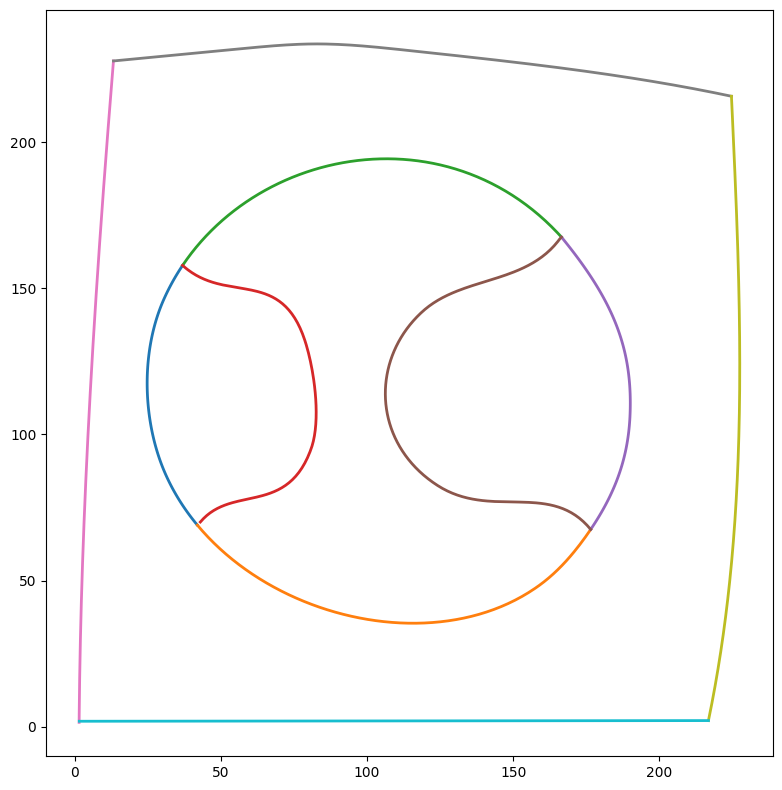

In [7]:
#this code is using the medium paper
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []

    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs

def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for XYs in paths_XYs:
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Read the CSV file
csv_path = '/content/frag0.csv'
paths_XYs = read_csv(csv_path)

# Create a blank image
img = np.ones((800, 800, 3), dtype=np.uint8) * 255

# Draw paths from the CSV on the image
for XYs in paths_XYs:
    for XY in XYs:
        points = XY.reshape((-1, 1, 2)).astype(np.int32)
        cv2.polylines(img, [points], isClosed=True, color=(0, 0, 0), thickness=2)

# Convert to grayscale
imgGry = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply threshold
ret, thrash = cv2.threshold(imgGry, 240, 255, cv2.THRESH_BINARY_INV)
contours, hierarchy = cv2.findContours(thrash, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Process each contour and print detected shapes
# Process each contour and print detected shapes
detected_shapes = []
for contour in contours:
    approx = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
    cv2.drawContours(img, [approx], 0, (0, 0, 0), 5)
    x, y, w, h = cv2.boundingRect(approx)
    x = int(x)
    y = int(y)
    label_x = int(x)
    label_y = int(y - 5)

    if len(approx) == 3:
        shape = "Triangle"
    elif len(approx) == 4:
        aspectRatio = float(w) / h
        if aspectRatio >= 0.95 and aspectRatio < 1.05:
            shape = "Square"
        else:
            shape = "Rectangle"
    elif len(approx) == 5:
        shape = "Pentagon"
    elif len(approx) == 10:
        shape = "Star"
    else:
        (x, y), (MA, ma), angle = cv2.fitEllipse(contour)
        aspectRatio = float(ma) / MA
        if aspectRatio >= 0.8 and aspectRatio <= 1.2:
            shape = "Circle"
        else:
            shape = "Ellipse"

    cv2.putText(img, shape, (label_x, label_y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))
    detected_shapes.append((shape, label_x, label_y))


# Display the result using cv2_imshow
cv2_imshow(img)

# Print detected shapes
for shape, x, y in detected_shapes:
    print(f"Detected {shape} at ({x}, {y})")

# Save the processed image
output_path = '/mnt/data/processed_image.png'
cv2.imwrite(output_path, img)

# Plot the paths
plot(paths_XYs)


NEW ONE AGAIN AT 12:35 A>M

In [14]:
#Plotting a Numpy array
import numpy as np
from scipy.spatial import ConvexHull

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs


def plot(paths_XYs, colours):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]

        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

    ax.set_aspect('equal')
    plt.show()




The below algorithm is used for regularization of shapes - works good for individual shapes which are not overlapping eachother

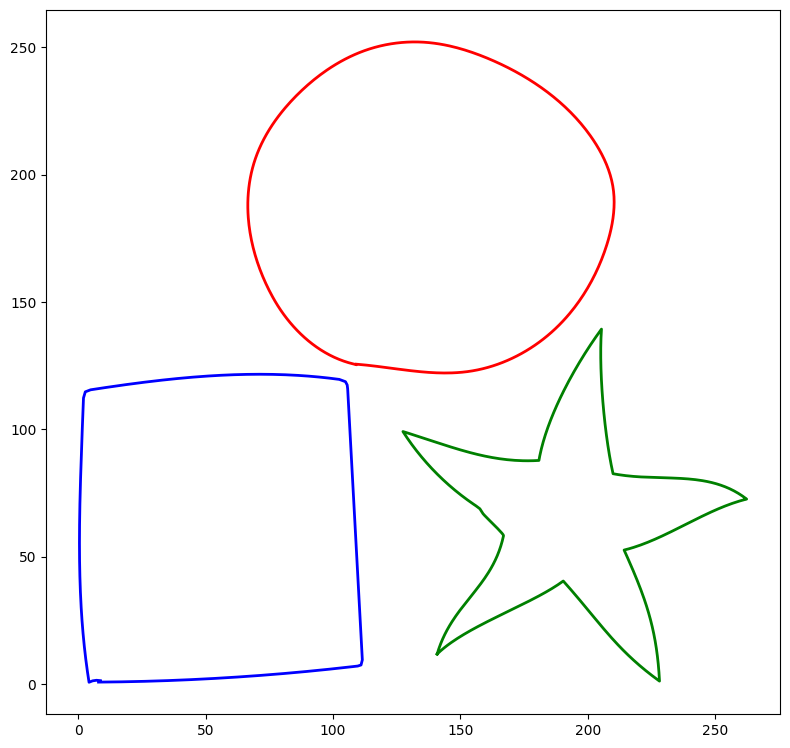

419
550
423


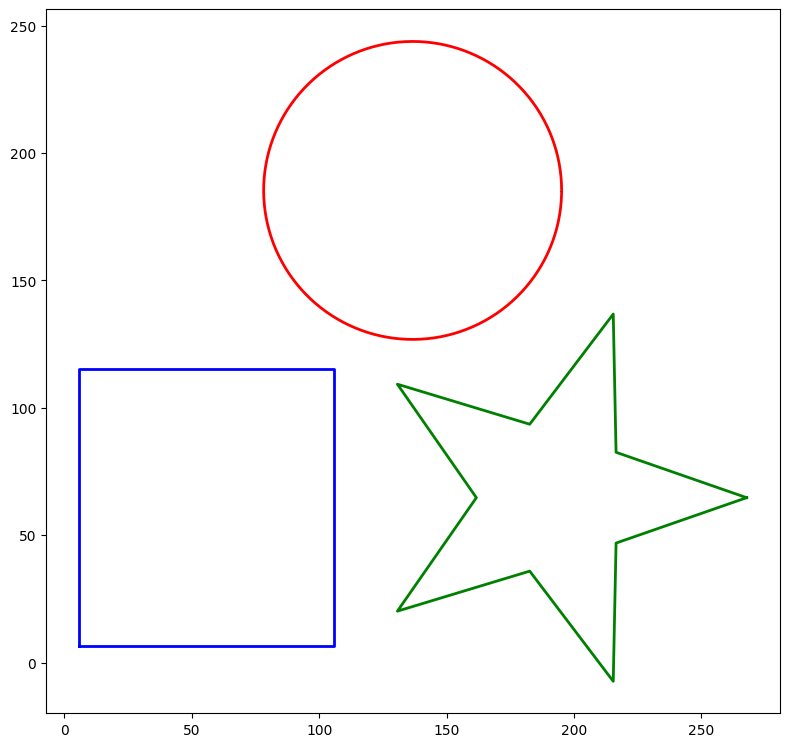

In [16]:
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage.measure import EllipseModel


def regularize_rounded_rectangle(points):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]

    # Approximate radius of rounded corners
    corner_radius = min(width, height) * 0.1

    # Define the corner points
    corners = [
        [min_coords[0] + corner_radius, min_coords[1] + corner_radius],
        [max_coords[0] - corner_radius, min_coords[1] + corner_radius],
        [max_coords[0] - corner_radius, max_coords[1] - corner_radius],
        [min_coords[0] + corner_radius, max_coords[1] - corner_radius]
    ]

    # Define the rectangle with rounded corners
    x = [p[0] for p in corners] + [corners[0][0]]
    y = [p[1] for p in corners] + [corners[0][1]]

    return np.column_stack((x, y))

def regularize_polygon(points):
    center = np.mean(points, axis=0)
    radius = np.mean(np.linalg.norm(points - center, axis=1))
    num_sides = len(points)

    angles = np.linspace(0, 2 * np.pi, num_sides, endpoint=False)
    x = center[0] + radius * np.cos(angles)
    y = center[1] + radius * np.sin(angles)

    return np.column_stack((x, y))

def regularize_line(points):
    if len(points) < 2:
        return np.array([])  # Not enough points to form a line

    # Fit a line to the points
    p1, p2 = points[0], points[-1]
    x = np.array([p1[0], p2[0]])
    y = np.array([p1[1], p2[1]])

    return np.column_stack((x, y))


def regularize_ellipse(points):
    if len(points) < 5:
        return np.array([])  # Not enough points to fit an ellipse

    # Fit an ellipse to the points
    ellipse = EllipseModel()
    ellipse.estimate(points)
    xc, yc, a, b, theta = ellipse.params

    num_points = len(points)
    theta_values = np.linspace(0, 2 * np.pi, num_points)
    x = xc + a * np.cos(theta_values) * np.cos(theta) - b * np.sin(theta_values) * np.sin(theta)
    y = yc + a * np.cos(theta_values) * np.sin(theta) + b * np.sin(theta_values) * np.cos(theta)

    return np.column_stack((x, y))



from scipy.interpolate import splprep, splev
def regularize_circle(points, max_width, max_height, scale_factor=0.9):
    center = np.mean(points, axis=0)
    radius = np.median(np.linalg.norm(points - center, axis=1))

    # Calculate the scale based on the minimum dimension
    min_dimension = min(max_width, max_height)
    scale = (min_dimension * scale_factor) / (2 * radius)

    num_points = len(points)
    theta = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    x = center[0] + radius * scale * np.cos(theta)
    y = center[1] + radius * scale * np.sin(theta)

    return np.column_stack((x, y))



def regularize_rectangle(points, max_width, max_height, scale_factor=0.9):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)

    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]

    scale_x = (max_width * scale_factor) / width
    scale_y = (max_height * scale_factor) / height

    # Center of the original rectangle
    center = np.mean(points, axis=0)

    x = [min_coords[0], max_coords[0], max_coords[0], min_coords[0], min_coords[0]]
    y = [min_coords[1], min_coords[1], max_coords[1], max_coords[1], min_coords[1]]

    # Scale and center the rectangle
    x = center[0] + (np.array(x) - center[0]) * scale_x
    y = center[1] + (np.array(y) - center[1]) * scale_y

    return np.column_stack((x, y))


def regularize_star(points):
    center = np.mean(points, axis=0)
    max_radius = np.max(np.linalg.norm(points - center, axis=1))
    min_radius = max_radius * 0.4  # Adjusted inner radius for more pronounced star

    num_points = 10  # Number of points in the star (5 outer, 5 inner)
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    radii = np.zeros(num_points)
    radii[::2] = max_radius  # Outer points
    radii[1::2] = min_radius  # Inner points

    x = center[0] + radii * np.cos(angles)
    y = center[1] + radii * np.sin(angles)

    # Ensure the star shape is closed
    x = np.append(x, x[0])
    y = np.append(y, y[0])

    return np.column_stack((x, y))


def calculate_perimeter(hull):
    perimeter = 0
    for i in range(len(hull.vertices)):
        p1 = hull.points[hull.vertices[i]]
        p2 = hull.points[hull.vertices[(i + 1) % len(hull.vertices)]]
        perimeter += np.linalg.norm(p1 - p2)
    return perimeter

def calculate_num_vertices(points):
    # Implement a method to estimate or count the number of vertices in the shape
    # This can involve techniques such as convex hull vertices count, etc.
    hull = ConvexHull(points)
    return len(hull.vertices)

def identify_shape(points):
    print(len(points))
    if len(points) < 3:
        return 'unknown'  # Not enough points to determine shape

    hull = ConvexHull(points)
    hull_area = hull.volume
    hull_perimeter = calculate_perimeter(hull)

    if hull_perimeter == 0:
        return 'unknown'

    compactness = 4 * np.pi * hull_area / (hull_perimeter ** 2)



    if compactness > 0.88:

        return 'circle'

    aspect_ratio = calculate_aspect_ratio(points)
    if 0.8 < aspect_ratio < 1.2:
        plot_paths
        return 'rectangle'

    num_vertices = calculate_num_vertices(points)

    # Adjust aspect ratio threshold for star
    if num_vertices > 5 and (aspect_ratio < 0.9 or aspect_ratio > 2) and compactness < 0.9:

        return 'star'

    return 'unknown'


def calculate_max_extents(points):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]
    return width, height

def calculate_aspect_ratio(points):
    hull = ConvexHull(points)
    hull_points = hull.points[hull.vertices]

    # Calculate distances between vertices
    dists = [np.linalg.norm(hull_points[i] - hull_points[(i + 1) % len(hull_points)]) for i in range(len(hull_points))]
    width, height = sorted(dists)[:2]

    return max(width, height) / min(width, height)


def regularize_shape(points):
    if len(points) == 0:
        return np.array([])  # Return empty array for empty input

    # Determine the maximum extents from the irregular shape
    max_width, max_height = calculate_max_extents(points)

    shape_type = identify_shape(points)

    if shape_type == 'circle':
        return regularize_circle(points, max_width, max_height)
    elif shape_type == 'rectangle':
        return regularize_rectangle(points, max_width, max_height)
    elif shape_type=='star':
        return regularize_star(points)
    else:
      return bezier_curve_fit(points)


def bezier_curve_fit(points, num_points=100):
    tck, u = splprep(points.T, s=0)
    u_new = np.linspace(u.min(), u.max(), num_points)
    x_new, y_new = splev(u_new, tck, der=0)
    return np.vstack((x_new, y_new)).T

colours = ['r', 'g', 'b', 'y']
pathXY=read_csv('/content/isolated.csv')
regularized_path_XYs = []
plot(pathXY,colours)

for path in pathXY:
    regularized_path = []
    for shape in path:
        regularized_shape = regularize_shape(shape)
        regularized_path.append(regularized_shape)
    regularized_path_XYs.append(regularized_path)
plot(regularized_path_XYs, colours)

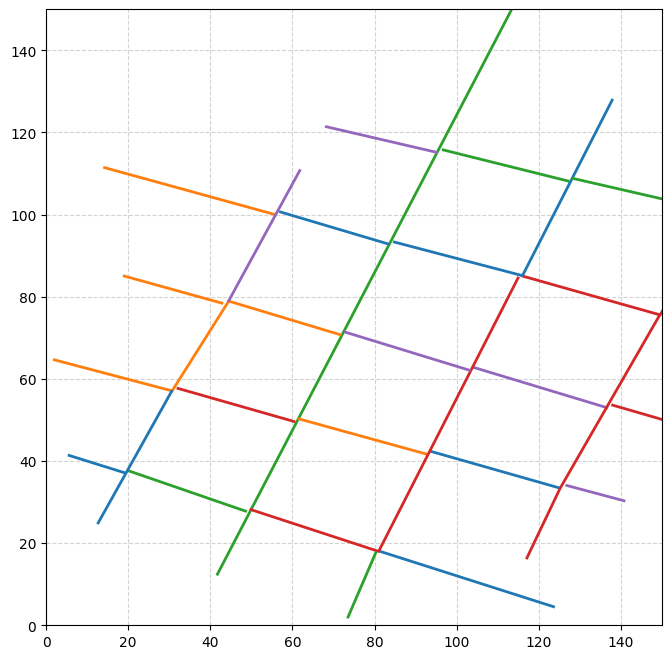

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from rdp import rdp

# Function to apply RDP algorithm
def apply_rdp(path_XYs, epsilon=1.0):
    simplified_paths = []
    for path in path_XYs:
        simplified_path = [rdp(segment, epsilon=epsilon) for segment in path]
        simplified_paths.append(simplified_path)
    return simplified_paths

# Function to plot the simplified paths
def plot_paths(path_XYs, colours):
    fig, ax = plt.subplots(figsize=(8, 8))
    color_idx = 0
    for path in path_XYs:
        for segment in path:
            if len(segment) > 0:
                segment = np.array(segment)
                ax.plot(segment[:, 0], segment[:, 1], c=colours[color_idx % len(colours)], linewidth=2)
        color_idx += 1
    ax.set_aspect('equal')
    plt.xlim(0, 150)
    plt.ylim(0, 150)
    plt.grid(True, which='both', color='lightgray', linestyle='--')
    plt.show()

# Load and process data
csv_path = "/content/frag2.csv"
path_XYs = read_csv(csv_path)
simplified_paths = apply_rdp(path_XYs, epsilon=1.0)

# Define new colors (e.g., different shades of blue and green)
colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Different shades of blue, orange, green, red, and purple

# Plot the result with the new colors
plot_paths(simplified_paths, colours)


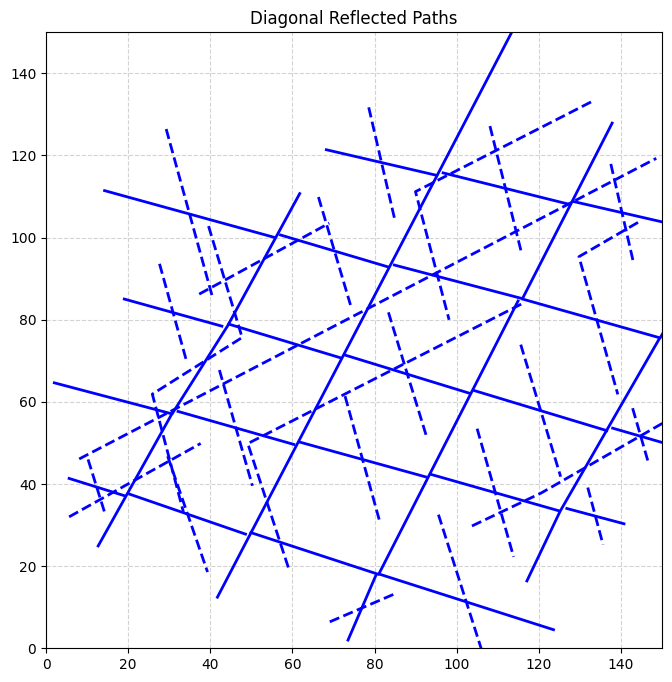

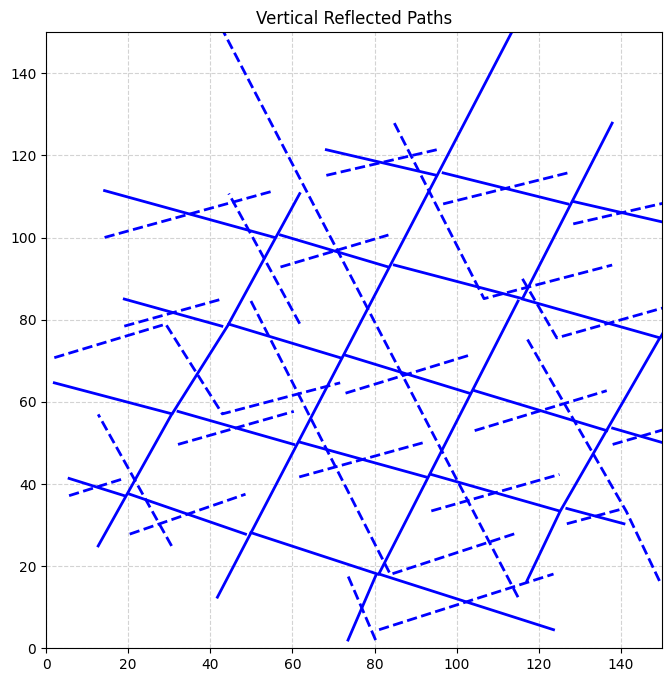

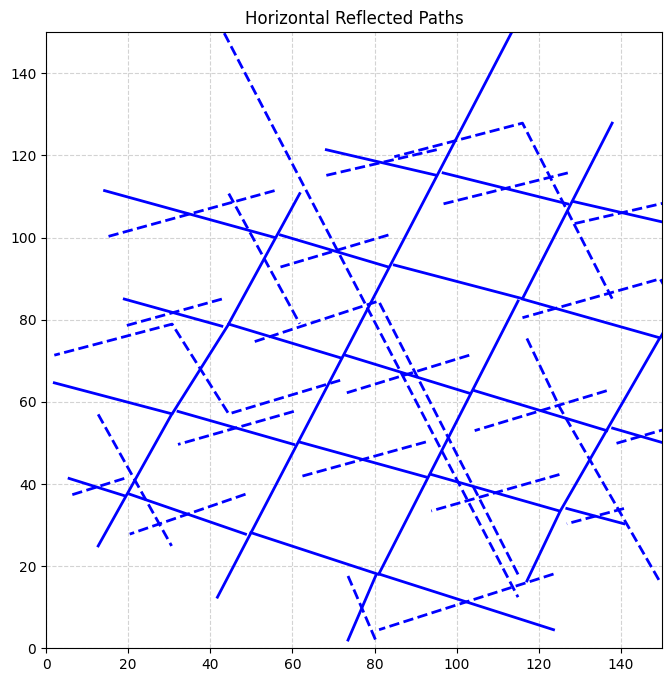

In [19]:
def reflect_across_vertical(points, x_line):
    return np.array([[2 * x_line - x, y] for x, y in points])

def reflect_across_horizontal(points, y_line):
    return np.array([[x, 2 * y_line - y] for x, y in points])

def reflect_across_diagonal(points, line_point, line_direction):
    line_point = np.array(line_point)
    line_direction = np.array(line_direction) / np.linalg.norm(line_direction)
    reflected_points = []
    for point in points:
        point = np.array(point)
        projection_length = np.dot(point - line_point, line_direction)
        projection = line_point + projection_length * line_direction
        reflection = 2 * projection - point
        reflected_points.append(reflection)
    return np.array(reflected_points)

def find_and_reflect_symmetry(paths, symmetry_type):
    reflected_paths = []
    for path in paths:
        reflected_path = []
        for segment in path:
            if symmetry_type == "vertical":
                x_line = (segment[:, 0].min() + segment[:, 0].max()) / 2
                reflected_segment = reflect_across_vertical(segment, x_line)
            elif symmetry_type == "horizontal":
                y_line = (segment[:, 1].min() + segment[:, 1].max()) / 2
                reflected_segment = reflect_across_horizontal(segment, y_line)
            elif symmetry_type == "diagonal":
                line_point = [(segment[:, 0].min() + segment[:, 0].max()) / 2,
                              (segment[:, 1].min() + segment[:, 1].max()) / 2]
                line_direction = [1, 1]  # 45-degree line
                reflected_segment = reflect_across_diagonal(segment, line_point, line_direction)
            reflected_path.append(reflected_segment)
        reflected_paths.append(reflected_path)
    return reflected_paths

def plot_original_and_reflected_paths(original_paths, reflected_paths, colour, symmetry_type):
    fig, ax = plt.subplots(figsize=(8, 8))

    for original_path, reflected_path in zip(original_paths, reflected_paths):
        for segment, reflected_segment in zip(original_path, reflected_path):
            if len(segment) > 0:
                segment = np.array(segment)
                ax.plot(segment[:, 0], segment[:, 1], c=colour, linewidth=2)
                ax.plot(reflected_segment[:, 0], reflected_segment[:, 1], c=colour, linestyle='--', linewidth=2)

    ax.set_aspect('equal')
    plt.xlim(0, 150)
    plt.ylim(0, 150)
    plt.grid(True, which='both', color='lightgray', linestyle='--')
    plt.title(f"{symmetry_type.capitalize()} Reflected Paths")
    plt.show()



# Define the color to be used
single_colour = 'blue'

# Find and plot symmetry for diagonal reflection
reflected_paths_diagonal = find_and_reflect_symmetry(simplified_paths, "diagonal")
plot_original_and_reflected_paths(simplified_paths, reflected_paths_diagonal, single_colour, "diagonal")

# Find and plot symmetry for vertical reflection
reflected_paths_vertical = find_and_reflect_symmetry(simplified_paths, "vertical")
plot_original_and_reflected_paths(simplified_paths, reflected_paths_vertical, single_colour, "vertical")

# Find and plot symmetry for horizontal reflection
reflected_paths_horizontal = find_and_reflect_symmetry(simplified_paths, "horizontal")
plot_original_and_reflected_paths(simplified_paths, reflected_paths_horizontal, single_colour, "horizontal")




Plotting input curves...


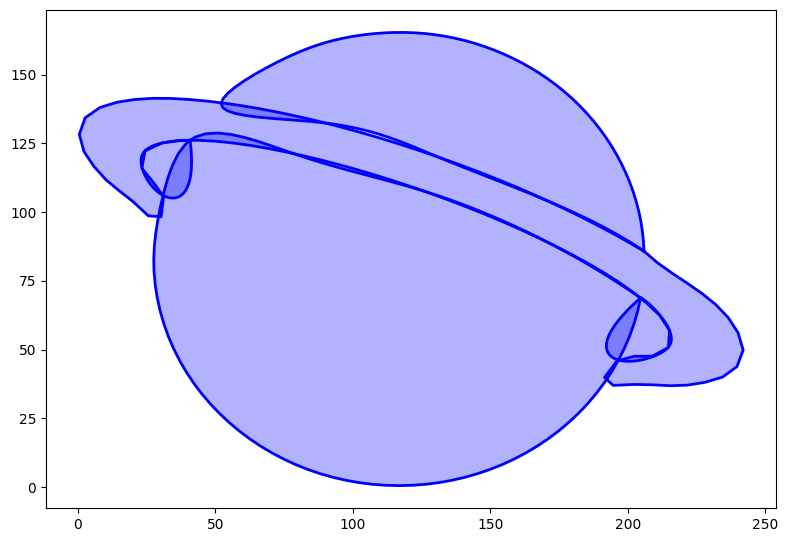

Error in connectivity analysis: 'MultiPolygon' object is not subscriptable
Plotting filled curves...


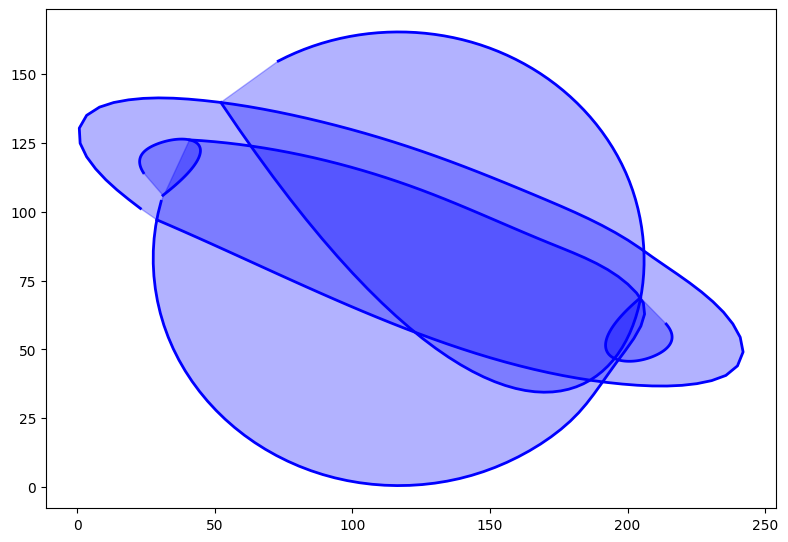

Occlusion is over 


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.interpolate import splprep, splev
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
from shapely.ops import unary_union
from shapely.validation import make_valid
from rdp import rdp
import svgwrite



def rdp_simplify(path_XYs, epsilon=1.0):
    simplified_paths = []
    for path in path_XYs:
        simplified_path = []
        for shape in path:
            if len(shape) > 2:
                simplified_shape = rdp(shape, epsilon=epsilon)
                simplified_path.append(simplified_shape)
            else:
                simplified_path.append(shape)
        simplified_paths.append(simplified_path)
    return simplified_paths

def fill_occlusions(paths_XYs):
    filled_paths = []
    for path in paths_XYs:
        filled_path = []
        for shape in path:
            if len(shape) > 2:  # Only process shapes with more than 2 points
                hull = ConvexHull(shape)
                filled_shape = shape[hull.vertices]
            else:
                filled_shape = shape
            filled_path.append(filled_shape)
        filled_paths.append(filled_path)
    return filled_paths

def fit_bezier_curve(points, num_points=100):
    if len(points) < 2:
        return points
    tck, u = splprep([points[:, 0], points[:, 1]], s=0)
    u_fine = np.linspace(0, 1, num_points)
    x_fine, y_fine = splev(u_fine, tck)
    return np.vstack((x_fine, y_fine)).T

def plot_curves(paths_XYs, colour):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for XYs in paths_XYs:
        for XY in XYs:
            if len(XY) > 2:
                bezier_curve = fit_bezier_curve(XY)
                ax.plot(bezier_curve[:, 0], bezier_curve[:, 1], c=colour, linewidth=2)
                ax.fill(bezier_curve[:, 0], bezier_curve[:, 1], c=colour, alpha=0.3)
            else:
                ax.plot(XY[:, 0], XY[:, 1], c=colour, linewidth=2)
                ax.fill(XY[:, 0], XY[:, 1], c=colour, alpha=0.3)
    ax.set_aspect('equal')
    plt.show()

def analyze_connectivity(paths_XYs):
    polygons = []
    for path in paths_XYs:
        for shape in path:
            if len(shape) > 2:
                polygon = Polygon(shape)
                if polygon.is_valid:
                    polygons.append(polygon)
                else:
                    repaired_polygon = make_valid(polygon)
                    polygons.append(repaired_polygon)

    if not polygons:
        return "Disconnected"

    try:
        multi_polygon = MultiPolygon(polygons)
        unified_polygon = unary_union(multi_polygon)

        if isinstance(unified_polygon, Polygon):
            return "Connected"
        elif isinstance(unified_polygon, MultiPolygon):
            if len(unified_polygon.geoms) == 1:
                return "Connected"
            else:
                return "Disconnected"
        elif isinstance(unified_polygon, GeometryCollection):
            valid_polygons = [geom for geom in unified_polygon.geoms if isinstance(geom, Polygon) and geom.is_valid]
            if valid_polygons:
                multi_polygon = MultiPolygon(valid_polygons)
                if len(multi_polygon.geoms) == 1:
                    return "Connected"
                else:
                    return "Disconnected"
            else:
                return "Disconnected"
    except Exception as e:
        print(f"Error in connectivity analysis: {e}")
        return "Disconnected"

def process_csv_and_fill_occlusions(input_csv, colours):
    # Process input CSV
    input_paths_XYs = read_csv(input_csv)

    # Apply RDP simplification
    simplified_paths_XYs = rdp_simplify(input_paths_XYs, epsilon=1.0)
    print("Plotting input curves...")
    plot_curves(simplified_paths_XYs, colours)
    input_result = analyze_connectivity(simplified_paths_XYs)

    # Fill occlusions
    filled_paths_XYs = fill_occlusions(simplified_paths_XYs)
    print("Plotting filled curves...")
    plot_curves(filled_paths_XYs, colours)
    output_result = analyze_connectivity(filled_paths_XYs)



    if input_result == "Disconnected" and output_result == "Connected":
        print("Occlusion is over ")
    else:
        print("No change in connectivity")

def polylines2svg(paths_XYs, filename, colour):
    dwg = svgwrite.Drawing(filename, profile='tiny')
    for XYs in paths_XYs:
        for XY in XYs:
            points = [(x, y) for x, y in XY]
            dwg.add(dwg.polyline(points, stroke=colour, fill='none', stroke_width=2))
    dwg.save()

single_colour = 'blue'
input_csv = '/content/occlusion2.csv'
# Process input CSV and apply RDP simplification, plot curves and save SVG
process_csv_and_fill_occlusions(input_csv, single_colour)

paths_XYs = read_csv(input_csv)
simplified_paths_XYs = rdp_simplify(paths_XYs, epsilon=1.0)
polylines2svg(simplified_paths_XYs, 'simplified_paths.svg', single_colour)

